In [1]:
import json
import os
import math
import html
import re
import joblib
import pickle
from IPython.core.display import display, HTML


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

### Setup
#### Create two dataframes:
1. **df_init**: all covid stories
2. **df_balanced**: balanced sample of df_init used for testing/training ML models

In [2]:
def load_data(directory):
    data_dicts = []
    for file in os.listdir(directory):
        with open(os.path.join(directory, file), 'r') as f:
            data_dict = json.load(f)
        data_dicts.append(data_dict)
    return data_dicts

In [3]:
def build_dataframe(data_dicts):
    return pd.json_normalize(data_dicts)


def reformat_dataframe(df, columns_to_keep):
    df = df.rename(columns_to_keep, axis=1)
    df = df[list(columns_to_keep.values())]
    return df

In [4]:
def drop_unlabeled_data(df, column):
    return df[(df[column] == True) | (df[column] == False)]


def balance_data(df, column):
    df_grouped = df.groupby(column)
    sample_size = df_grouped.size().min()

    def sample(df):
        return df.sample(sample_size)

    df_grouped_sampled = df_grouped.apply(sample)
    df_sampled = pd.DataFrame(df_grouped_sampled)
    df_sampled = df_sampled.droplevel(level=0)
  
    return df_sampled

In [5]:
def print_useful_info(df,column="_label", name= ""):
    print(f"# stories {name}\t: {df.shape[0]} ({100*(df[df[column] == True].shape[0]/df.shape[0]):.2f}% COVID)")

In [6]:
directory = '../data/news_articles/balanced_dataset/'

columns_to_keep = {
    'LABEL.WANT_ON_MAP': '_label',
    'ARTICLE.TEXT': 'text',
    'ARTICLE.TITLE': 'title',
}
label = '_label' # put '_' in front so that it does not conflict with columns for tfidf vectors later on
content_columns = ['text','title']

data = load_data(directory)

df_init = build_dataframe(data)
df_init = reformat_dataframe(df_init, columns_to_keep)
df_init = drop_unlabeled_data(df_init, label)
df_init[label] = df_init[label].astype(bool)

df_balanced = balance_data(df_init, label)
    
print("data loaded")
print_useful_info(df_init, name='all data')
print_useful_info(df_balanced, name='balanced data')

data loaded
# stories all data	: 1589 (10.70% COVID)
# stories balanced data	: 340 (50.00% COVID)


# NEW: SPLIT INTO CONSISTENT TRAIN, TEST GROUPS

In [7]:
df_balanced['train'] = np.random.rand(340,) > .2  # this is hacky, but it gets the job done

In [8]:
df_balanced['train'].mean()  # percent of stories used for training

0.7852941176470588

In [9]:
df_train = df_balanced[df_balanced['train']].copy()
df_test = df_balanced[~df_balanced['train']].copy()

# NEW: SPLIT INTO CONSISTENT TRAIN, TEST GROUPS

### Rule Based Model

In [23]:
class RuleBasedModel:
    def __init__(self, keyword_string):
        self.keyword_string = keyword_string
        
    def predict(self, X):
        return np.array([
            self._predict(*x)
            for _, x in X.iterrows()
        ])
    
    def _predict(self, title, body):
        keywords_in_title = re.findall(self.keyword_string, title.lower())
        if any(keywords_in_title):
            return True
        
        keywords_in_body = re.findall(self.keyword_string, body.lower())
        return len(keywords_in_body) > 5

In [24]:
def plot_cf_matrix(labels, predicted, title="", normalize=None):
    ax= plt.subplot()
    matrix = confusion_matrix(labels, predicted, normalize=normalize)
    display = ConfusionMatrixDisplay(matrix, display_labels=['Not COVID','COVID'])
    display.plot(cmap='Blues', ax=ax)
    ax.set_title(title)

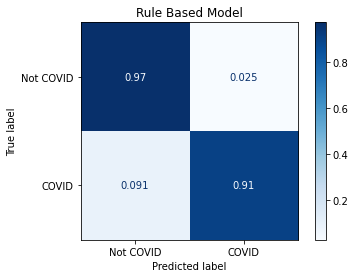

In [25]:
labels = df_test[label]

model = RuleBasedModel('covid|corona|pandem|epidem|mask|quarant|vaccine|lockdown')
predicted = model.predict(df_test[["title", "text"]])

plot_cf_matrix(labels, predicted, title="Rule Based Model", normalize='true')

In [26]:
def markup(string):
    for keyword in 'covid|corona|pandem|epidem|mask|quarant|vaccine|lockdown'.split('|'):
        string = re.sub(
            keyword, f'<span style="background-color: #ffd1d1"><b>{keyword}</b></span>', 
            string,
        )
        string = re.sub(
            keyword.upper(), f'<span style="background-color: #ffd1d1"><b>{keyword.upper()}</b></span>', 
            string,
        )
    return string

In [27]:
# view false positives

false_positive = (predicted == True) & (labels == False)

for index, row in df_test[false_positive].head(10).iterrows():
    display(HTML(markup(html.escape(row['text']))))
    display(HTML('<br><br>'))

In [30]:
# view false negatives

false_negative = (predicted == False) & (labels == True)

for index, row in df_test[false_negative].head(10).iterrows():
    display(HTML(markup(html.escape(row['text']))))
    display(HTML('<br><br>'))

### Keyword model 

In [31]:
def count_keywords(df, columns, keywords):
    for keyword in keywords:
        
        def count_keyword(string):
            return sum(
                keyword in word
                for word in string.lower().split()
            )

        df[keyword] = df[columns].applymap(count_keyword).sum(axis=1)
        
    return df


def train_classifiers(classifiers, x,y, debug=False):
    for cls in classifiers:
        if debug: print(type(cls).__name__ + "... ",end="")
        cls.fit(x,y)
        if debug: print("done")

In [32]:
def plot_confusion_matrices(classifiers, x,y,title="",normalize=None, nrows = 1):
    ncols = math.ceil(len(classifiers)/nrows)
    fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(ncols*5,nrows*3.7))
    for cls, ax in zip(classifiers, axes.flatten()):
        plot_confusion_matrix(
            cls,
            x, 
            y,
            ax=ax, 
            cmap='Blues',
            normalize=normalize,
            display_labels=['Not COVID', 'COVID'],
        )
        ax.title.set_text(type(cls).__name__)
    fig.suptitle(title, fontsize='xx-large',ha='left')
    plt.tight_layout()  
    plt.show()

In [33]:
article_keywords = [
    'covid',
    'corona',
    'pandem',
    'epidem',
    'mask',
    'quarant',
    'vaccine',
]

classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
]

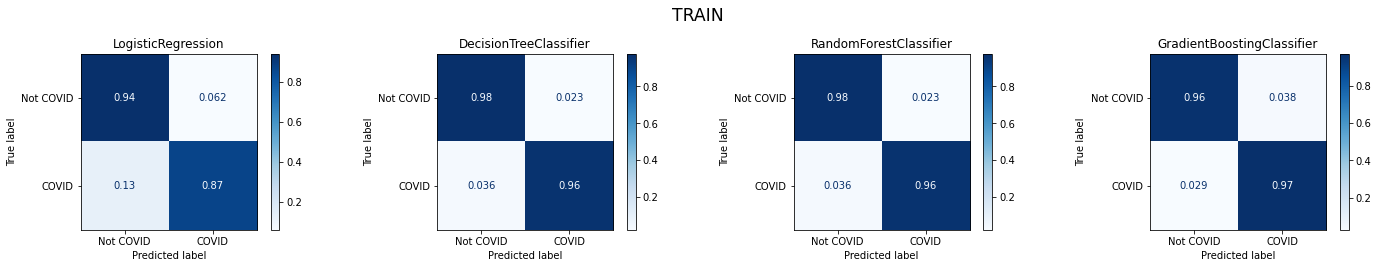

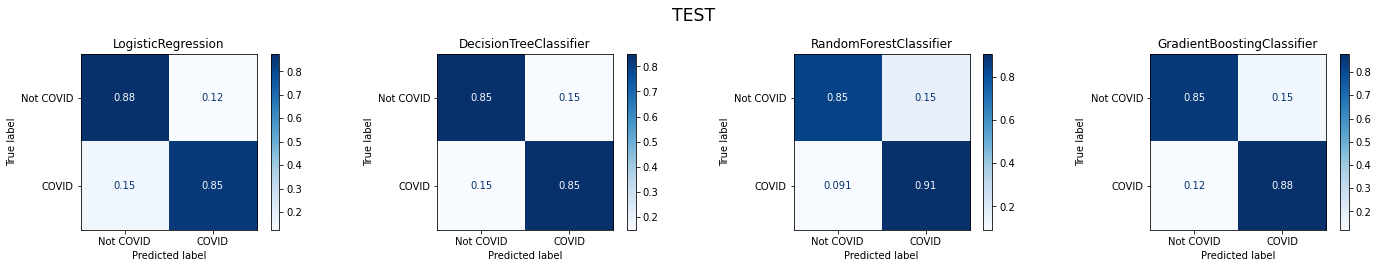

In [34]:
df_train = count_keywords(df_train, content_columns, article_keywords)
df_test = count_keywords(df_test, content_columns, article_keywords)


x_train = df_train[article_keywords]
y_train = df_train[label]

x_test = df_test[article_keywords]
y_test = df_test[label]

train_classifiers(classifiers, x_train, y_train)

plot_confusion_matrices(classifiers, x_train, y_train, title="TRAIN", normalize='true')
plot_confusion_matrices(classifiers, x_test, y_test, title="TEST", normalize='true')

In [35]:
for classifier in classifiers:
    print(classifier)

    false_positive = (predicted == False) & (labels == True)
    predicted = classifier.predict(df_test[article_keywords])

    for index, row in df_test[false_positive].head(10).iterrows():
        display(HTML(markup(html.escape(row['text']))))
        display(HTML('<br><br>'))

LogisticRegression()


DecisionTreeClassifier()


RandomForestClassifier()


GradientBoostingClassifier()


### TF IDF VECTORIZE

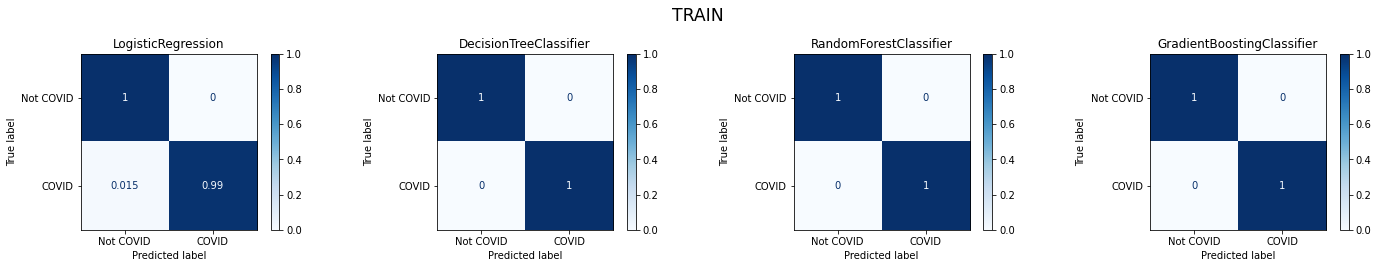

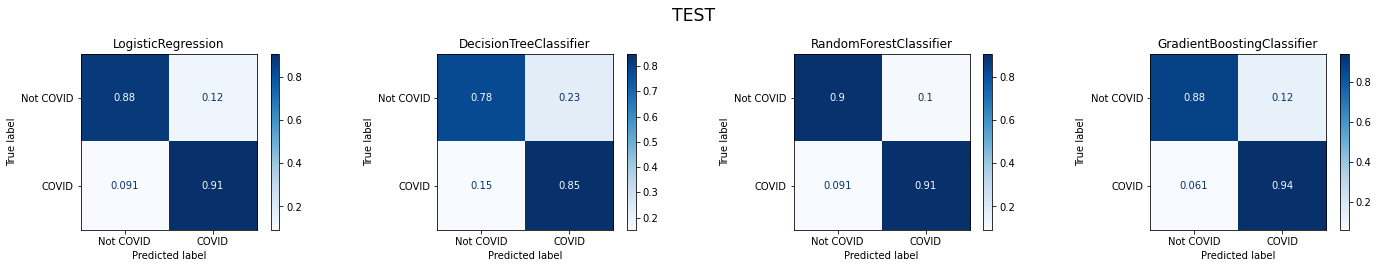

In [36]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')

x_train = tfidf_vectorizer.fit_transform(df_train['text'])
y_train = df_train[label]

x_test = tfidf_vectorizer.transform(df_test['text'])
y_test = df_test[label]

train_classifiers(classifiers, x_train, y_train)

plot_confusion_matrices(classifiers, x_train, y_train,title="TRAIN", normalize='true')
plot_confusion_matrices(classifiers, x_test, y_test,title="TEST", normalize='true')

In [37]:
for classifier in classifiers:
    print(classifier)

    false_positive = (predicted == False) & (labels == True)
    predicted = classifier.predict(x_test)

    for index, row in df_test[false_positive].head(10).iterrows():
        display(HTML(markup(html.escape(row['text']))))
        display(HTML('<br><br>'))

LogisticRegression()


DecisionTreeClassifier()


RandomForestClassifier()


GradientBoostingClassifier()
